# Prepare sample point neighborhood stats within each study region
### *use odense as an example in this notebook
Description: This script is for preparing all sample points indicators/stats.  
All the cities should run this script first to get the pre-prepared sample points before running the aggregation scripts (aggr.py)

**City-specific input data**  

| Input data | Geometry | Description |
| --- | --- | --- |
| aos_nodes_30m_line | point | Public open space pseudo entry points (points on boundary of park every 20m within 30m of road) |
| clean_intersections_12m |	point |	Clean intersections (not required; counts are associated with pop_ghs_2015) |
| dest_type	| NA (non-spatial) |	Summary of destinations and counts |
| destinations |	point	| OSM destinations retrieved using specified definitions (only require: supermarkets, convenience,  pt_any --- use dest_name_full to determine, will need to combine convenience destinations) |
| pop_ghs_2015	| polygon	| 250m hex grid, associated with area_sqkm (fixed), population estimate (2015), population per sq km, intersection count, intersections per sq km |
| urban_sample_points |	point |	Sample points in urban region (every 30m along pedestrian network) |
| urban_study_region | polygon | Urban study region (intersection of city boundary and GHS 2015 urban centre layer) |


**Two outputs:**
1. average poplulation and intersection density per sample point
2. accessibility, daily living and walkability score per sample point

notice: must close the geopackage connection in QGIS.Otherwise, an error occurred when reading

In [1]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import numpy as np
import os
import setup_sp as ssp # functions for setting up sample point stats used in this notebook
import setup_config as sc # import project config parameters

import time
from multiprocessing import Pool, cpu_count, Value, Manager, Process
from functools import partial
import json
import fiona
import sys
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# get the work directory
dirname = os.path.abspath('')

# the configuration file should put in the "/configuration" folder located at the same folder as scripts
jsonFile = 'configuration/' + sys.argv[1]
jsonPath = os.path.join(dirname, jsonFile)

# load city-specific configeration file (e.g. Odense)
with open('configuration/olomouc.json') as json_file:
    config = json.load(json_file)

In [3]:
# read projected graphml filepath
graphmlProj_path = os.path.join(dirname, config['folder'],
                                    config['graphmlProj_name'])

# define original graphml filepath
graphml_path = os.path.join(dirname, config['folder'],
                            config['graphmlName'])

G_proj = ssp.read_proj_graphml(graphmlProj_path, graphml_path, config['to_crs'])

Read network from disk.


In [4]:
#  geopackage path where to read all the required layers and save processing layers to it
gpkgPath = os.path.join(dirname, config['folder'], config['geopackagePath'])
   
# geopackage path where to save processing layers
gpkgPath_output = os.path.join(dirname, config['folder'], config['geopackagePath_output'])

# copy input geopackage to output geopackage, if not already exist
if not os.path.isfile(gpkgPath_output):
    print('Create study region sample point output file')
    for layer in fiona.listlayers(gpkgPath):
        gpkgPath_input = gpd.read_file(gpkgPath, layer=layer)
        gpkgPath_input.to_file(gpkgPath_output, layer=layer, driver='GPKG')
else:
    print('Study region sample point output file exists')
        
# read hexes in memory, hex layer in city-specific geopackage contain population and intersection info.
hexes = gpd.read_file(gpkgPath_output, layer=sc.parameters['hex250'])

# get nodes from the city projected graphml
gdf_nodes = ox.graph_to_gdfs(G_proj, nodes=True, edges=False)
gdf_nodes.osmid = gdf_nodes.osmid.astype(int)
gdf_nodes = gdf_nodes.drop_duplicates(subset='osmid')
# keep only the unique node id column
gdf_nodes_simple = gdf_nodes[['osmid']].copy()
del gdf_nodes

Study region sample point output file exists


/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


## 1. Calculate average poplulation and intersection density for each sample point in study regions
**The steps are as follows:**
1. use the OSM pedestrain network (graphml in disk) to generate local 1600m neighborhood per urban sample points (sample point in disk)
2. load 250m hex grid from disk with population and network intersections density data
3. then calculate population and intersection density within each local walkable neighborhood (1600m) by averaging the hex level pop and intersection density data; final result is urban sample point dataframe with osmid, pop density, and intersection density.

In [5]:
startTime = time.time()

# read pop density and intersection density filed names from the  city-specific configeration file
pop_density = sc.samplePoint_fieldNames[
    'sp_local_nh_avg_pop_density']
intersection_density = sc.samplePoint_fieldNames[
    'sp_local_nh_avg_intersection_density']

# read from disk if exist
if os.path.isfile(os.path.join(dirname, config['folder'],
                     config['tempCSV'])):
    print('Read poplulation and intersection density from local file.')
    gdf_nodes_simple = pd.read_csv(os.path.join(dirname, config['folder'],
                     config['tempCSV']))

# otherwise,calculate using single thred or multiprocessing
else:
    print('Calculate average poplulation and intersection density.')
    
    # Graph for Walkability analysis should not be directed
    G_proj = ox.get_undirected(G_proj)
    
    # read search distance from json file, the default should be 1600m
    # the search distance is used to defined the radius of a sample point as a local neighborhood
    distance = sc.parameters['search_distance']

    # get the nodes GeoDataFrame row length for use in later iteration
    rows = gdf_nodes_simple.shape[0]

    # using single thread approach
    # create counter for loop
    val = Value('i', 0)
    df_result = gdf_nodes_simple['osmid'].apply(
        ssp.calc_sp_pop_intect_density,
        args=(G_proj, hexes, pop_density, intersection_density, distance,
              val, rows))
    # Concatenate the average of population and intersections back to the df of sample points
    gdf_nodes_simple = pd.concat([gdf_nodes_simple, df_result], axis=1)

    # save the pop and intersection density to a CSV file
    gdf_nodes_simple.to_csv(
            os.path.join(dirname, config['folder'],
                         config['tempCSV']))

# set osmid as index
gdf_nodes_simple.set_index('osmid', inplace=True, drop=False)
print('The time to finish average pop and intersection density is: {}'.
          format(time.time() - startTime))


Read poplulation and intersection density from local file.
The time to finish average pop and intersection density is: 0.033030033111572266


In [6]:
# show sample point pop and intersection density data
gdf_nodes_simple.head()

,Unnamed: 0,osmid,sp_local_nh_avg_pop_density,sp_local_nh_avg_intersection_density
osmid,,,,
250871808,250871808,250871808,2350.081556,108.842195
1598881793,1598881793,1598881793,NaN,NaN
250871810,250871810,250871810,2484.868047,113.847269
2057306114,2057306114,2057306114,NaN,NaN
2057306116,2057306116,2057306116,NaN,NaN


## Calculate accessibility to POI (supermarket,convenience,pt,pos), daily living and walkability for sample points
**steps as follow:**
   1. using pandana packadge to calculate distance to access from sample points to destinations (daily living destinations, public open space)
   2. calculate accessibiity score per sample point: transform accessibility distance to binary measure: 1 if access <= 500m, 0 otherwise
   3. calculate daily living score by summing the accessibiity scores to all POIs (excluding pos)
   4. calculate walkability score per sample point: get zscores for daily living accessibility, populaiton density and intersections pop_density; sum these three zscores at sample point level


In [7]:
print('Calculate assessbility to POIs.')
# read accessibility distance from configuration file, which is 500m
distance = sc.parameters['accessibility_distance']

# create the pandana network, use network nodes and edges
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G_proj)
net = ssp.create_pdna_net(gdf_nodes, gdf_edges,predistance=distance)

# read 'daily living destinations' point layer (supermarket,convenience,pt) from disk
gdf_poi1 = gpd.read_file(gpkgPath_output,
                         layer=sc.parameters['destinations'])

# read field names from json file
poi_names = [
    sc.parameters['supermarket'],
    sc.parameters['convenience'], sc.parameters['PT']
]


# define output field names from nearest nodes distance
dist_fieldNames1 = [
    'sp_nearest_node_supermarket_dist',
    'sp_nearest_node_convenience_dist',
    'sp_nearest_node_pt_dist'
]

# zip the input and output field names
names1 = list(zip(poi_names, dist_fieldNames1))

# calculate the distance from each node to POI
gdf_poi_dist1 = ssp.cal_dist_node_to_nearest_pois(gdf_poi1, distance, net, *(names1))

# read open space 'aos_nodes_30m_line' layer from geopackage
gdf_poi2 = gpd.read_file(gpkgPath_output, layer=sc.parameters['pos'])


names2 = [(sc.parameters['pos'],
           'sp_nearest_node_pos_dist')]

# calculate the distance from each node to public open space,
# filterattr=False to indicate the layer is 'aos_nodes_30m_line'
gdf_poi_dist2 = ssp.cal_dist_node_to_nearest_pois(gdf_poi2,
                                 distance,
                                 net,
                                 *names2,
                                 filterattr=False)

# concatenate two dataframes into one
gdf_nodes_poi_dist = pd.concat([gdf_nodes, gdf_poi_dist1, gdf_poi_dist2],
                               axis=1)

dist_fieldNames1.append(
    'sp_nearest_node_pos_dist')

# set index of gdf_nodes_poi_dist, using 'osmid' as the index
gdf_nodes_poi_dist.set_index('osmid', inplace=True, drop=False)
# drop unuseful columns
gdf_nodes_poi_dist.drop(['geometry', 'id', 'lat', 'lon', 'y', 'x', 'highway', 'ref'],
    axis=1,
    inplace=True)

# replace -999 values as nan
gdf_nodes_poi_dist = round(gdf_nodes_poi_dist,0).replace(-999,np.nan).astype('Int64')

# read sample points from disk (in city-specific geopackage)
samplePointsData = gpd.read_file(
    gpkgPath_output, layer=sc.parameters['samplePoints'])

# create 'hex_id' for sample point, if it not exists
if 'hex_id' not in samplePointsData.columns.tolist():
    samplePointsData = ssp.createHexid(samplePointsData, hexes)

samplePointsData.set_index('point_id',inplace=True)

fulldist_FieldNames = [
    sc.samplePoint_fieldNames['sp_supermarket_dist_m'],
    sc.samplePoint_fieldNames['sp_convenience_dist_m'],
    sc.samplePoint_fieldNames['sp_pt_dist_m'],
    sc.samplePoint_fieldNames['sp_pos_dist_m']
]


full_nodes = ssp.create_full_nodes(samplePointsData, gdf_nodes_simple, gdf_nodes_poi_dist, dist_fieldNames1,
                                   fulldist_FieldNames, pop_density, intersection_density)

# convert full distance to binary index
binary_FieldNames = [
    sc.samplePoint_fieldNames['sp_access_supermarket_binary'],
    sc.samplePoint_fieldNames['sp_access_convenience_binary'],
    sc.samplePoint_fieldNames['sp_access_pt_binary'],
    sc.samplePoint_fieldNames['sp_access_pos_binary']
]

names3 = list(zip(fulldist_FieldNames, binary_FieldNames))
full_nodes = ssp.convert_dist_to_binary(full_nodes, *names3)


samplePointsData = samplePointsData[['hex_id', 'edge_ogc_fid','geometry']].join(
                                  full_nodes,
                                  how='left')


Calculate assessbility to POIs.


/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Create hex_id for sample points


In [25]:
# create new field for daily living score,sum accessibility to POIs to get the daily living scores 
#(e.g. supermarket, public transport, and convenience store, exclude public open space)

daily_living = sc.samplePoint_fieldNames['sp_daily_living_score']

samplePointsData[daily_living] = samplePointsData[binary_FieldNames[:-1]].sum(axis=1)

oriFieldNames = [
    sc.samplePoint_fieldNames['sp_local_nh_avg_pop_density'],
    sc.samplePoint_fieldNames['sp_local_nh_avg_intersection_density'],
    sc.samplePoint_fieldNames['sp_daily_living_score']
]
newFieldNames = [
    sc.samplePoint_fieldNames['sp_zscore_local_nh_avgpopdensity'],
    sc.samplePoint_fieldNames['sp_zscore_local_nh_avgintdensity'],
    sc.samplePoint_fieldNames['sp_zscore_daily_living_score']
]
samplePointsData = ssp.cal_zscores(samplePointsData,oriFieldNames,newFieldNames)


# sum these three zscores for walkability
walkability_index = sc.samplePoint_fieldNames['sp_walkability_index']
samplePointsData[walkability_index] = samplePointsData[newFieldNames].sum(axis=1)

int_fields = ['hex_id', 'edge_ogc_fid']
float_fields = fulldist_FieldNames + binary_FieldNames  + [daily_living] + [pop_density] + [intersection_density] + newFieldNames + [walkability_index]

samplePointsData[int_fields] = samplePointsData[int_fields].astype(int)
samplePointsData[float_fields] = samplePointsData[float_fields].astype(float)

# save the sample points with all the desired results to a new layer in geopackage
#samplePointsData.reset_index().to_file(
#    gpkgPath,
#    layer=sc.parameters['samplepointResult'],
#    driver='GPKG')    


In [16]:
len(samplePointsData)

28337

In [13]:
samplePointsData.columns

Index(['hex_id', 'edge_ogc_fid', 'geometry', 'sp_supermarket_dist_m',
       'sp_convenience_dist_m', 'sp_pt_dist_m', 'sp_pos_dist_m',
       'sp_local_nh_avg_pop_density', 'sp_local_nh_avg_intersection_density',
       'sp_access_supermarket_binary', 'sp_access_convenience_binary',
       'sp_access_pt_binary', 'sp_access_pos_binary', 'sp_daily_living_score',
       'sp_zscore_local_nh_avgpopdensity', 'sp_zscore_local_nh_avgintdensity',
       'sp_zscore_daily_living_score', 'sp_walkability_index'],
      dtype='object')

Text(0.5, 0.95, 'Local Sample Point walkability')

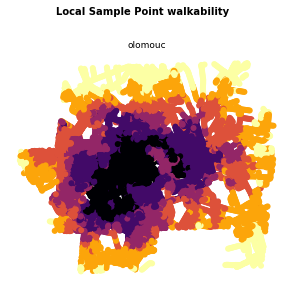

In [14]:
col='sp_walkability_index'

fig, ax = plt.subplots(figsize=(5, 5))

#plot indicators
ax = samplePointsData.plot(ax=ax, column=col, scheme='NaturalBreaks', k=6, cmap='inferno_r', edgecolor='none')

ax.set_title(config['study_region'], fontsize=9)
ax.set_axis_off()

# add a title to the figure
fig.suptitle('Local Sample Point walkability', y=0.95, fontsize=10, weight='bold')